# GEM

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import GEM
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/gem.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [8]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "patterns_per_exp": [1, 2, 5, 10],
    "memory_strength": [0.2, 0.5, 0.7, 0.9],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[GEM] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = GEM(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Training model 1/16
Training model 2/16
Training model 3/16
Training model 4/16
Training model 5/16
Training model 6/16
Training model 7/16
Training model 8/16
Training model 9/16
Training model 10/16
Training model 11/16
Training model 12/16
Training model 13/16
Training model 14/16
Training model 15/16
Training model 16/16


In [9]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [10]:
best_hyperparameters

{'patterns_per_exp': 2, 'memory_strength': 0.5}

## Evaluation metrics definition

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [12]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [13]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = GEM(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 128.59it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 104.3000
	Loss_MB/train_phase/train_stream/Task000 = 1.1311
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6477
100%|██████████| 469/469 [00:03<00:00, 129.26it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.5000
	Loss_MB/train_phase/train_stream/Task000 = 0.8237
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6285
100%|██████████| 469/469 [00:03<00:00, 129.35it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 108.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.4601
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6259
100%|██████████| 469/469 [00:03<00:00, 129.39it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:26<03:57, 26.42s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0836
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15de16880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [19:06<1:29:16, 669.56s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 120.6708
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15df31550>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [29:15<1:14:55, 642.16s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 118.5871
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15ea00f10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [33:49<49:39, 496.62s/it]  

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 118.1932
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15ee59d90>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [35:27<29:25, 353.07s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 123.2704
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15f1d4fd0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [37:08<17:49, 267.31s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 123.0951
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15f446d00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.5921, 0.7649, 0.7550, 0.8072, 0.8452, 0.9401, 0.0930, 0.1598, 0.1036,
         0.0975],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [40:31<12:18, 246.14s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 116.5139
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15f969dc0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.5921, 0.7649, 0.7550, 0.8072, 0.8452, 0.9401, 0.0930, 0.1598, 0.1036,
         0.0975],
        [0.5773, 0.7115, 0.7037, 0.7596, 0.7347, 0.8939, 0.9402, 0.1348, 0.1148,
         0.1065],
    

 80%|████████  | 8/10 [42:31<06:52, 206.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 123.2853
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15fac72e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.5921, 0.7649, 0.7550, 0.8072, 0.8452, 0.9401, 0.0930, 0.1598, 0.1036,
         0.0975],
        [0.5773, 0.7115, 0.7037, 0.7596, 0.7347, 0.8939, 0.9402, 0.1348, 0.1148,
         0.1065],
    

 90%|█████████ | 9/10 [44:21<02:55, 175.96s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 123.9010
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1608dbbe0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.5921, 0.7649, 0.7550, 0.8072, 0.8452, 0.9401, 0.0930, 0.1598, 0.1036,
         0.0975],
        [0.5773, 0.7115, 0.7037, 0.7596, 0.7347, 0.8939, 0.9402, 0.1348, 0.1148,
         0.1065],
    

100%|██████████| 10/10 [46:21<00:00, 278.10s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 121.3414
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x160a69be0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4292.2080
	EvalStream/Acc_Matrix = 
tensor([[0.9116, 0.1250, 0.0755, 0.1217, 0.1320, 0.0958, 0.1223, 0.1047, 0.1010,
         0.1131],
        [0.8434, 0.9256, 0.1011, 0.1106, 0.1397, 0.0810, 0.1004, 0.1007, 0.1090,
         0.1660],
        [0.7784, 0.8572, 0.9340, 0.0993, 0.1089, 0.0975, 0.0798, 0.1183, 0.0942,
         0.1306],
        [0.7863, 0.8274, 0.8937, 0.9345, 0.0697, 0.0700, 0.0890, 0.0973, 0.0947,
         0.1143],
        [0.6812, 0.8146, 0.8724, 0.8665, 0.9385, 0.0907, 0.0873, 0.1016, 0.1148,
         0.1468],
        [0.5921, 0.7649, 0.7550, 0.8072, 0.8452, 0.9401, 0.0930, 0.1598, 0.1036,
         0.0975],
        [0.5773, 0.7115, 0.7037, 0.7596, 0.7347, 0.8939, 0.9402, 0.1348, 0.1148,
         0.1065],
    

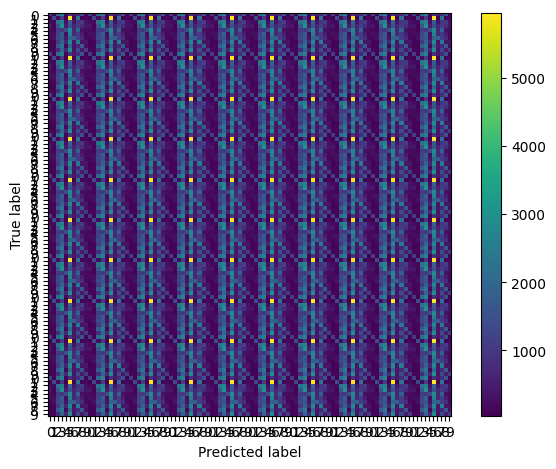

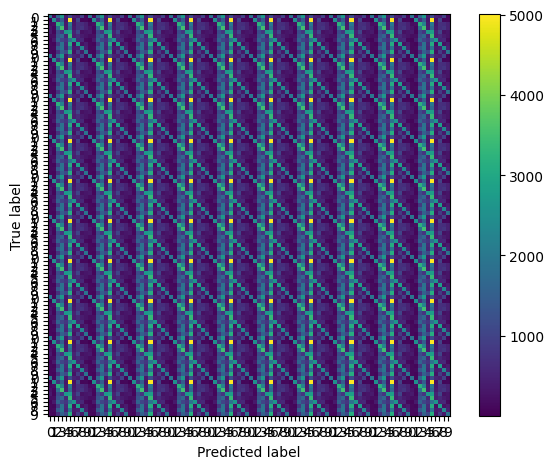

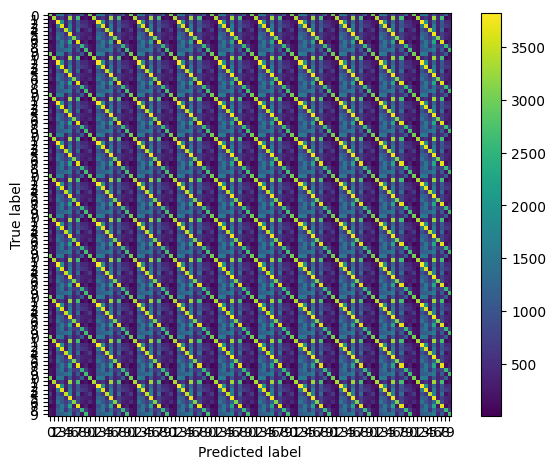

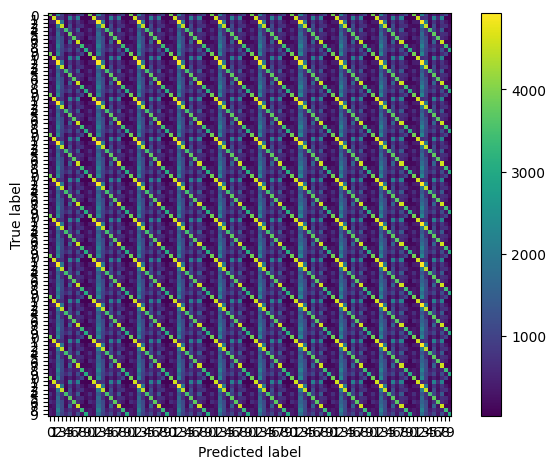

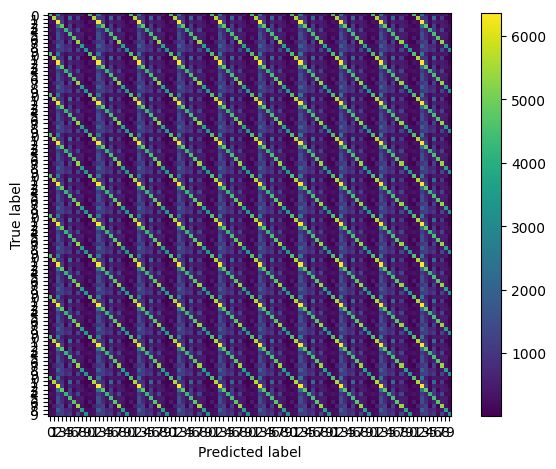

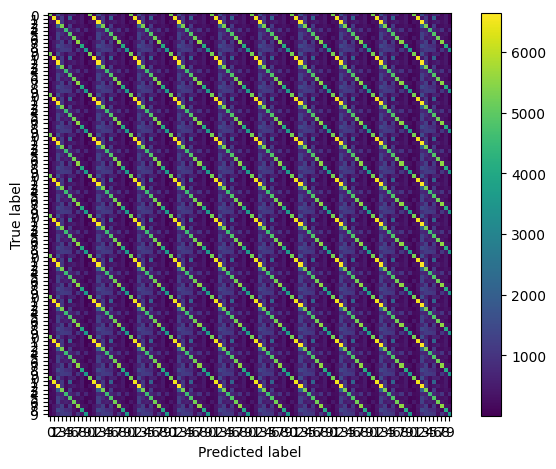

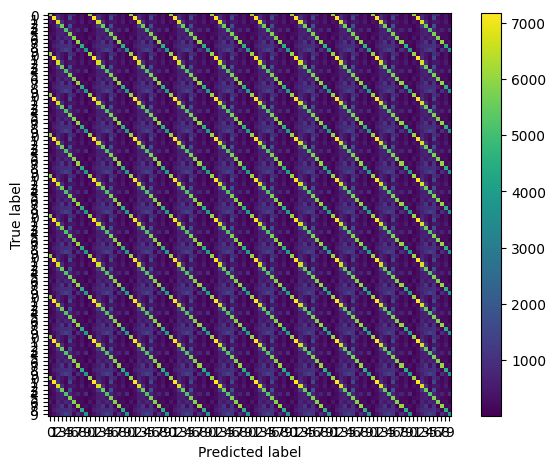

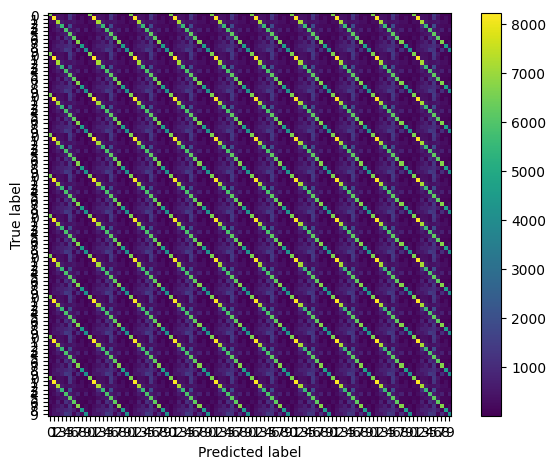

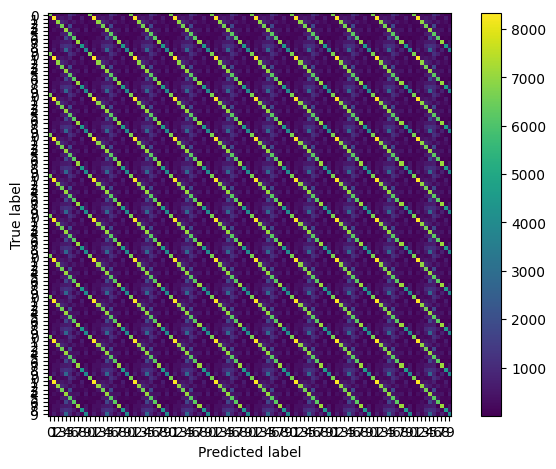

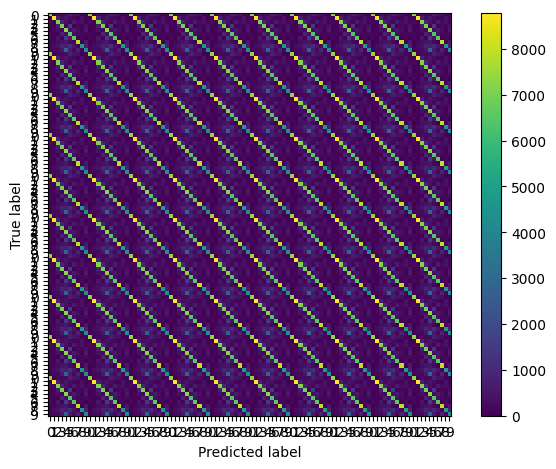

In [14]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [15]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [16]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [17]:
weights = model_plugins[0].weights

# Store metrics

In [18]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))